In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Main.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/GestureDataset")
# zip_ref.close()

In [1]:
import cv2
import numpy as np
import os
import pickle
import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
import glob

In [4]:
def segment(image, threshold=25):
    global bg
    diff = cv2.absdiff(bg.astype("uint8"), image)

    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]

    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(cnts) == 0:
        return
    else:
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)

In [5]:
DATASET_PATH = '/content/drive/MyDrive/GestureDataset/data'

dataset_path = os.path.join(DATASET_PATH, '*')
import glob
dataset_path = glob.glob(dataset_path)
dataset_path

['/content/drive/MyDrive/GestureDataset/data/thumbsdown',
 '/content/drive/MyDrive/GestureDataset/data/thumbsup',
 '/content/drive/MyDrive/GestureDataset/data/blank',
 '/content/drive/MyDrive/GestureDataset/data/five',
 '/content/drive/MyDrive/GestureDataset/data/ok',
 '/content/drive/MyDrive/GestureDataset/data/fist']

(200, 200, 3)


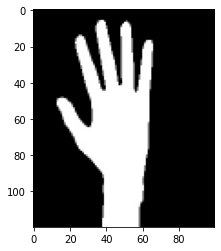

In [7]:
import cv2
image = cv2.imread('/content/drive/MyDrive/GestureDataset/data/five/hand1(393).jpg')
image = cv2.resize(image,(100, 120))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [8]:
import os

# folder path
dir_path = r'/content/drive/MyDrive/GestureDataset/data/blank'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)


File count: 1616


In [ ]:
loaded_images = []

list_of_gestures = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

for path in range(0, len(dataset_path)):
    dataset_path = "/content/drive/MyDrive/GestureDataset/data/" + str(list_of_gestures[path])
    gesture_path = os.path.join(dataset_path, '*')
    import glob
    gest_path = glob.glob(gesture_path)
    k = 0
    for i in range(0, len(gest_path)):
        if k < 1600:
            image = cv2.imread(gest_path[i])
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image,(100, 120))
            loaded_images.append(gray_image)
        k=k+1
print(len(loaded_images))

outputVectors = []
for i in range(1, 1601):
    outputVectors.append([1, 0, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 1, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 1, 0, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 1, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 1, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 0, 1])

print(len(outputVectors))

9600
9600


In [ ]:
X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(X.shape)
print(y.shape)

(9600, 120, 100)
(9600, 6)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 100, 120, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 120, 1)
print(X_train.shape)
print(X_test.shape)

(7680, 100, 120, 1)
(1920, 100, 120, 1)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam


model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100,120, 1))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 118, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 98, 118, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 59, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 59, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 57, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 47, 57, 64)       2

In [ ]:
# Training the model with data
model.fit(X_train, y_train,
          batch_size=128,
          epochs=8,
          verbose=1,
          validation_data=(X_test, y_test))
filename = '/content/drive/MyDrive/new_train_model.sav'
pickle.dump(model, open(filename, 'wb'))
model.save("/content/drive/MyDrive/new_train_model.h5")

Epoch 1/8
60/60 [==============================] - 13s 77ms/step - loss: 3.4667 - categorical_accuracy: 0.7419 - val_loss: 0.2671 - val_categorical_accuracy: 0.8625
Epoch 2/8
60/60 [==============================] - 4s 71ms/step - loss: 0.3024 - categorical_accuracy: 0.8616 - val_loss: 0.1593 - val_categorical_accuracy: 0.9365
Epoch 3/8
60/60 [==============================] - 4s 71ms/step - loss: 0.2347 - categorical_accuracy: 0.8971 - val_loss: 0.0841 - val_categorical_accuracy: 0.9781
Epoch 4/8
60/60 [==============================] - 4s 72ms/step - loss: 0.1952 - categorical_accuracy: 0.9152 - val_loss: 0.0648 - val_categorical_accuracy: 0.9932
Epoch 5/8
60/60 [==============================] - 4s 71ms/step - loss: 0.1450 - categorical_accuracy: 0.9315 - val_loss: 0.0563 - val_categorical_accuracy: 0.9839
Epoch 6/8
60/60 [==============================] - 4s 71ms/step - loss: 0.1257 - categorical_accuracy: 0.9406 - val_loss: 0.0225 - val_categorical_accuracy: 0.9958
Epoch 7/8
60/60

In [ ]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc*100)+"%")

60/60 [==============================] - 1s 8ms/step - loss: 0.0117 - categorical_accuracy: 0.9969
Accuracy: 99.6874988079071%


# Predict 

In [ ]:
import keras
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/new_train_model.h5")

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Datasets/data/s4/100.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = cv2.resize(gray_image, [100, 120])
gray_image = gray_image.reshape(1, 100, 120, 1)
prediction = reconstructed_model.predict(gray_image)
predicted_class = np.argmax(prediction)
if predicted_class == 0:
  print("Blank")
elif predicted_class == 1:
  print("OK")
elif predicted_class == 2:
  print("Thumbs Up")
elif predicted_class == 3:
  print("Thumbs Down")
elif predicted_class == 4:
  print("Punch")
elif predicted_class == 5:
  print("High Five")

1/1 [==============================] - 0s 15ms/step
OK


# Save

In [ ]:
reconstructed_model_json = reconstructed_model.to_json()
with open("/content/drive/MyDrive/model_gestures.json", "w") as json_file:
  json_file.write(reconstructed_model_json)